In [60]:
from minisom import MiniSom
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import random
from Square import *

data = pd.read_csv('SomXYZ.csv')
data = data.values
#moim zdaniem chyba nie potrzeba tutaj normalizować danych, ewentualnie po zmianach wartości x oraz y z jest zawsze -1 do 1
print(data.shape)

(10000, 3)


In [61]:
class Square:
  def __init__(self, points, x_position, y_position, bad_square = False):
    self.points = points
    self.points_to_train = np.concatenate(self.points)
    self.x_position = x_position
    self.y_position = y_position
    self.bad_square = bad_square
    self.colored_points = []
  def get_position(self):
    return [self.x_position, self.y_position]
  
  def randomize_points(self, randomization_percent):
    self.bad_square = True
    points_count = len(self.points)
    points_to_randomize = int((points_count * randomization_percent) / 100)
    random_indices = np.random.choice(range(points_count), points_to_randomize)
    for index in random_indices:
        self.points[index][2] += random.uniform(-1,1) #zmienia Z
    self.points_to_train = np.concatenate(self.points)

  def color_my_points(self, color):
    rgb = self.hex_to_rgb(color)
    for i in range(self.points.shape[0]):
      self.colored_points.append(np.concatenate((self.points[i], rgb)))
    return self.colored_points

    
  def hex_to_rgb(self, hex_code):
    hex_code = hex_code.lstrip('#')  # Remove leading '#' if present
    return np.array(tuple(int(hex_code[i:i+2], 16) for i in (0, 2, 4)))

  def svd_method(self):
    centroid = np.mean(self.points, axis=0)
    centered_points = self.points - centroid
    U, S, Vh = np.linalg.svd(centered_points)
    normal_vector = Vh[:, -1] #do sprawdzenia
    self.normal_vector = normal_vector
    return normal_vector
  
  def moments_method(self):
    centroid = np.mean(self.points, axis=0)
    centered_points = self.points - centroid
    Mx = np.mean(self.points[:,0])
    My = np.mean(self.points[:,1])
    Mz = np.mean(self.points[:,2])

    Mxx = np.mean((self.points[:,0] - Mx) ** 2)
    Myy = np.mean((self.points[:,1] - My) ** 2)
    Mzz = np.mean((self.points[:,2] - Mz) ** 2)
    Mxy = np.mean((self.points[:,0] - Mx)  * (self.points[:,1] - My))
    Mxz = np.mean((self.points[:,0] - Mx)  * (self.points[:,2] - Mz))
    Myz = np.mean((self.points[:,1] - My)  * (self.points[:,2] - Mz))

    a = Mxx / (Mxx + Myy + Mzz)
    b = Myy / (Mxx + Myy + Mzz)
    c = Mzz / (Mxx + Myy + Mzz)
    d = - (a*Mx + b*My + c*Mz)

    self.normal_vector = np.array([a,b,c])
    return np.array([a,b,c])



    
  

In [62]:
x_values = data[:,0]
y_values = data[:,1]
z_values = data[:,2]
min_x = min(x_values)
min_y = min(y_values)
max_x = max(x_values)
max_y = max(y_values)

In [63]:
#nasz group_array nie ma sensu gdyz dzieli on listę np od recordu 0 do 50, a my poruszamy się w 3d więc musi dzielić np x: 0-5, y: 0-5
#mam na to napisaną metodę w c#
def group_array(data, x_jump, y_jump):
    x_segments_count = int((max(x_values) - min(x_values)) / x_jump)
    y_segments_count = int((max(y_values) - min(y_values)) / y_jump)
    segmented_points = []

    x = min_x
    y = min_y

    x_iterator = x_segments_count
    while(x_iterator >= 0):
       y_iterator = y_segments_count
       while(y_iterator >= 0):
          points = [point for point in data if point[0] >= x and point[0] < x + x_jump and point[1] >= y and point[1] < y+y_jump]
          x_pos = x_segments_count - x_iterator
          y_pos = y_segments_count - y_iterator
          segmented_points.append(Square(np.array(points), x_pos, y_pos))

          y += y_jump
          y_iterator = y_iterator -1
       x += x_jump
       y = min_y
       x_iterator = x_iterator - 1
    return(np.array(segmented_points))
    
squares = group_array(data,10,10)


In [64]:
squares[0].randomize_points(90) 
for square in squares:
    square.svd_method()
bad_square = squares[0]

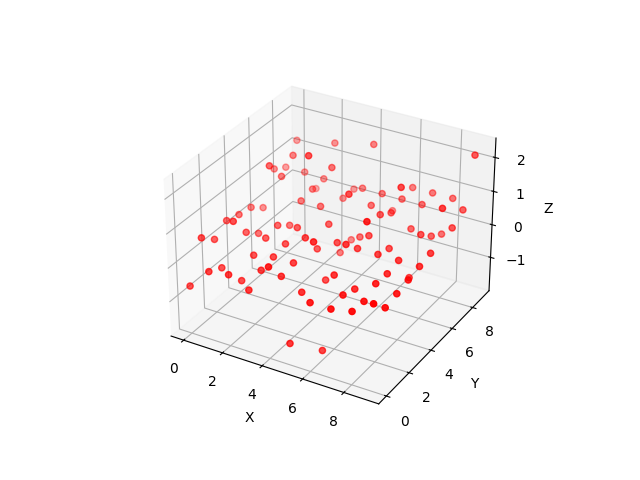

In [65]:
%matplotlib ipympl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d') 

# Wykres punktowy 3D
ax.scatter(bad_square.points[:,0], bad_square.points[:,1], bad_square.points[:,2], c='r', marker='o')  # c - kolor,  marker - kształt punktoru

# Ustawianie etykiet osi
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Wyświetlenie wykresu
plt.show()

TO EDYTOWAĆ DLA TRENINGU

In [66]:
som_3dim = len(bad_square.normal_vector) #ilość wag w neuronie
som_grid_size = 4

normal_vectors_to_train = np.array([x.normal_vector for x in squares]) #tworzenie listy składającej się z wektorów gotowych do treningu 
labels = np.array([int(x.bad_square) for x in squares])
label_names = {0: 'Dobre', 1: 'Złe'}

In [68]:
som = MiniSom(som_grid_size, som_grid_size, som_3dim, random_seed=42)
som.train(normal_vectors_to_train, 10000)

Koniec edytowania

In [69]:
print(som.winner(bad_square.normal_vector))
print(bad_square.get_position())

(0, 0)
[0, 0]


In [70]:
#tworzenie mapy kolorów
som_colors = np.empty((som_grid_size, som_grid_size), dtype='object')
color_idx = 0
for i in range(som_grid_size):
    for j in range (som_grid_size):
        som_colors[i,j] = colors[color_idx]
        color_idx+= 1
print(som_colors[1][0])

#FF4A46


In [71]:
#kolorowanie punktów sinusoidy
winner_pos = som.winner(bad_square.normal_vector)
col = som_colors[winner_pos[0], winner_pos[1]]
print(col)
bad_square.color_my_points(col)
for square in squares:
    winner_pos = som.winner(bad_square.normal_vector)
    col = som_colors[winner_pos[0], winner_pos[1]]
    square.color_my_points(col)


#000000


In [72]:
svd_normal_vector = bad_square.svd_method()
moments = bad_square.moments_method()
print(svd_normal_vector)
print(moments)

[-9.62348227e-02  7.92768629e-16 -9.95358658e-01]
[0.4882288 0.4882288 0.0235424]


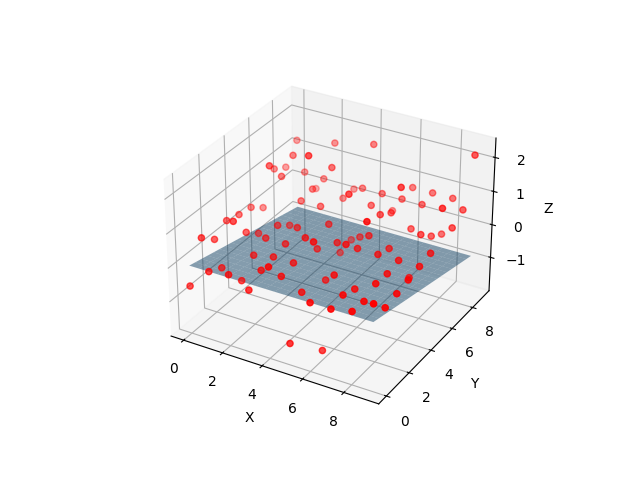

In [73]:
normal_x, normal_y, normal_Z = svd_normal_vector
# Create grid values
x = np.linspace(min(bad_square.points[:,1]), max(bad_square.points[:,1]),20) #x i y są zamienione miejscami ???
y = np.linspace(min(bad_square.points[:,0]), max(bad_square.points[:,0]),20)
xx, yy = np.meshgrid(x, y)

# Calculate Z values
Z = (-normal_x * xx - normal_y * yy) / normal_Z

# Create the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(bad_square.points[:,0], bad_square.points[:,1], bad_square.points[:,2], c='r', marker='o')  # c - kolor,  marker - kształt punktoru

ax.plot_surface(yy, xx, Z, alpha=0.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [74]:
import csv
def print_out_squares(squares): #zmien nazwe
    formatted_numbers = []
    with open('numbers.csv', 'w', newline='') as csvfile:
        for suqare in squares:
            points_to_print = suqare.colored_points
            writer = csv.writer(csvfile)
            for point in points_to_print:
                for num in point:
                    formatted_numbers.append("{}".format(num))
                writer.writerow(formatted_numbers)
                formatted_numbers = []
print_out_squares(squares)

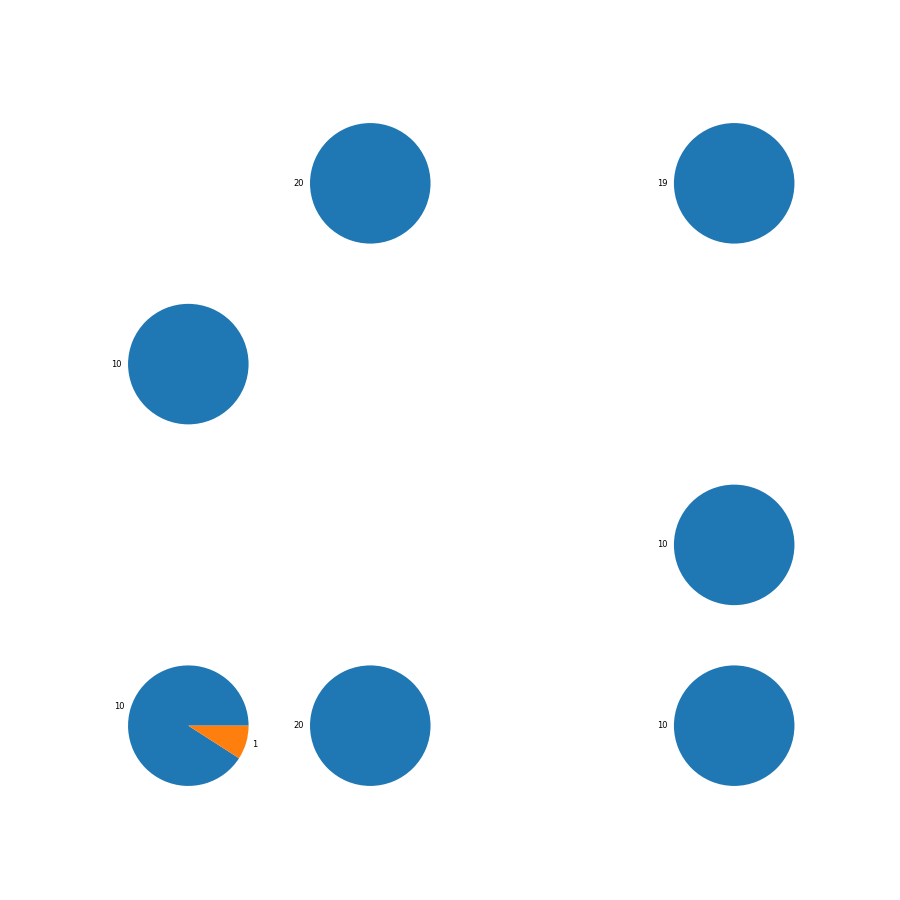

In [75]:
import matplotlib.gridspec as gridspec

labels_map = som.labels_map(normal_vectors_to_train, [label_names[t] for t in labels])

fig = plt.figure(figsize=(9, 9))
the_grid = gridspec.GridSpec(som_grid_size, som_grid_size, fig)
for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names.values()]
    plt.subplot(the_grid[som_grid_size-1-position[1],
                         position[0]], aspect=1)
    patches, autotexts = plt.pie(label_fracs, textprops={'fontsize': 6})  # Change here

    # Add labels to show the counts
    for t, count in zip(autotexts, label_fracs):
        if count > 0:  # Only display the number if the count is greater than zero
            t.set_text(f"{count:.0f}") 

plt.legend(patches, label_names.values(), bbox_to_anchor=(5.5, 9.5), ncol=3)
plt.show()

In [76]:
#przyjrzeć się metodzie som.labels_map()
#https://github.com/JustGlowing/minisom/blob/master/examples/Classification.ipynb
#przemyśleć czy całego generowania kwadratu nie przenieść do pliku od generowania daty
#nowa zaproponowana formuła danych: Dane: w jednej linii jeden kwadrat, Label, dla jednego kwadratu czy jest popsuty czy nie